# Setup

In [19]:
# ! pip install inferactively-pymdp
# ! pip install gymnasium

### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gymnasium as gym

from pymdp.agent import Agent
from pymdp import utils, maths

some plotitng functions

In [2]:
def plot_likelihood(matrix, xlabels = list(range(9)), ylabels = list(range(9)), title_str = "Likelihood distribution (A)"):
    """
    Plots a 2-D likelihood matrix as a heatmap
    """

    if not np.isclose(matrix.sum(axis=0), 1.0).all():
      raise ValueError("Distribution not column-normalized! Please normalize (ensure matrix.sum(axis=0) == 1.0 for all columns)")

    fig = plt.figure(figsize = (6,6))
    ax = sns.heatmap(matrix, xticklabels = xlabels, yticklabels = ylabels, cmap = 'gray', cbar = False, vmin = 0.0, vmax = 1.0)
    plt.title(title_str)
    plt.show()

def plot_grid(grid_locations, num_x = 3, num_y = 3 ):
    """
    Plots the spatial coordinates of GridWorld as a heatmap, with each (X, Y) coordinate
    labeled with its linear index (its `state id`)
    """

    grid_heatmap = np.zeros((num_x, num_y))
    for linear_idx, location in enumerate(grid_locations):
      y, x = location
      grid_heatmap[y, x] = linear_idx
    sns.set(font_scale=1.5)
    sns.heatmap(grid_heatmap, annot=True, cbar = False, fmt='.0f', cmap='crest')

def plot_point_on_grid(state_vector, grid_locations):
    """
    Plots the current location of the agent on the grid world
    """
    state_index = np.where(state_vector)[0][0]
    y, x = grid_locations[state_index]
    grid_heatmap = np.zeros((3,3))
    grid_heatmap[y,x] = 1.0
    sns.heatmap(grid_heatmap, cbar = False, fmt='.0f')

def plot_beliefs(belief_dist, title_str=""):
    """
    Plot a categorical distribution or belief distribution, stored in the 1-D numpy vector `belief_dist`
    """

    if not np.isclose(belief_dist.sum(), 1.0):
      raise ValueError("Distribution not normalized! Please normalize")

    plt.grid(zorder=0)
    plt.bar(range(belief_dist.shape[0]), belief_dist, color='r', zorder=3)
    plt.xticks(range(belief_dist.shape[0]))
    plt.title(title_str)
    plt.show()

def plot_beliefs_2D(belief_dist, title_str=""):
    """
    Plot a 2-D belief distribution, stored in the 2-D numpy matrix `belief_dist`
    """

    if not np.isclose(belief_dist.sum(), 1.0).all():
      raise ValueError("Distribution not column-normalized! Please normalize (ensure matrix.sum(axis=0) == 1.0 for all columns)")

    fig = plt.figure(figsize = (4,4))
    ax = sns.heatmap(belief_dist, cmap = 'RdYlGn', cbar = False, vmin = 0.0, vmax = 1.0, annot=True, linewidth=.5, fmt='.2f')
    plt.title(title_str)
    plt.show()


# Setup Environment

We've updated created an updated FrozenLake environment where the agent can still move after falling in holes. This environment also introduces the stay action, so that an agent can choose to stay in states it where it believes it will get preferred observations.

In [3]:
IS_SLIPPERY = True 

In [4]:
class FrozenLakeWrapper(gym.Wrapper):
  def __init__(self, env, is_slippery):
    super().__init__(env)
    # self.original_step = env.step
    # self.original_action_space = env.action_space
    self.is_slippery = is_slippery
    self.env_desc = np.array(env.unwrapped.desc, dtype='str')

    # add the stay action
    self.action_labels = ['left', 'down', 'right', 'up', 'stay']
    self.observation_labels = ['frozen', 'goal', 'hole']
    self.action_space = gym.spaces.Discrete(self.action_space.n + 1)

  def get_observation(self, state):
    if self.unwrapped.desc.flatten()[state] == b'H':
      return self.observation_labels.index('hole')
    elif self.unwrapped.desc.flatten()[state] == b'G':
      return self.observation_labels.index('goal')
    else:
      return self.observation_labels.index('frozen')

  def get_next_state(self, state, action):
    row, col = np.unravel_index(state, self.env_desc.shape)
    if action == 3 and row > 0:  # UP
        return state - self.env_desc.shape[1]
    elif action == 2 and col < self.env_desc.shape[1] - 1:  # RIGHT
        return state + 1
    elif action == 1 and row < self.env_desc.shape[0] - 1:  # DOWN
        return state + self.env_desc.shape[1]
    elif action == 0 and col > 0:  # LEFT
        return state - 1
    # if move in direction of wall don't move
    return state

  def step(self, action):
    '''
    Step now includes stay action, and is never "done"

    Returns:
      next location, temperature observation
    '''
    state = self.unwrapped.s
    obs = self.get_observation(state)
    # if stay do nothing
    if self.action_labels[action] == 'stay':
      return state, obs

    # Check if the agent is in a hole or the goal still move deterministicly
    if obs == self.observation_labels.index('hole') or obs == self.observation_labels.index('goal'):
        # change the direction of the sprite even though it won't acc move
        next_state, reward, done, truncated, info = self.env.step(action)
        # Manually update the state to reflect the action taken
        next_state = self.get_next_state(state, action)

        # Update the environment's internal state
        self.unwrapped.s = next_state
    else:
      # Take a step in the environment
      next_state, reward, done, truncated, info = self.env.step(action)

    return next_state, self.get_observation(next_state)

  # TODO: I found transition dynamics here: self.unwrapped.P. Can directly edit this to change and get the dynamics of movement
  def get_exact_transition_dynamics(self):
    '''
    This function returns the exact transition dynamics for the particular state
    Dynamics are represented using a probability matrix B[next state, curr state, action]
    '''
    num_states = self.observation_space.n
    num_actions = self.action_space.n
    B = np.zeros((num_states, num_states, num_actions))

    # directions we may slip in
    slip_directions = {
        0: [0, 1, 3], # going left  -> left, down, up
        1: [1, 0, 2], # going down  -> down, left, right
        2: [2, 1, 3], # going right -> right,down, up
        3: [3, 0, 2], # going up    -> up,   left, right
    }

    # iterate over all possible starting states
    for state in range(self.observation_space.n):
      x, y = np.unravel_index(state, self.env_desc.shape)
      # iterate over all actions we may take
      for action_index, action in enumerate(self.action_labels):
        # stay in same state w prob 1
        if action == 'stay':
          new_state = state
          B[new_state, state, action_index] = 1
        # if slipping is off or getting out of a hole/goal, always move in the intended direction
        elif not self.is_slippery or self.get_observation(state) != self.observation_labels.index('frozen'):
          new_state = self.get_next_state(state, action_index)
          B[new_state, state, action_index] = 1
        # slipping is on and we are on ice
        else:
          # consider each slip direction with equal probability
          for slip_action in slip_directions[action_index]:
            new_state = self.get_next_state(state, slip_action)
            B[new_state, state, action_index] += 1/3

    return B
  
  def get_naive_transition_dynamics(self):
    '''
    The naive transition dynamics make the assumption that a movement can lead to any one of the neighboring states with equal probability
    Dynamics are represented using a probability matrix B[next state, curr state, action]
    '''
    num_states = self.observation_space.n
    num_actions = self.action_space.n
    B = np.zeros((num_states, num_states, num_actions))

    # iterate over all possible starting states
    for state in range(self.observation_space.n):
      x, y = np.unravel_index(state, self.env_desc.shape)
      # iterate over all actions we may take
      for action_index, action in enumerate(self.action_labels):
        # lets get the adjacent states
        adjacent_states = []
        # cmpute the adjacent states (taking into account edges)
        for a in range(num_actions):
          adjacent_states.append(self.get_next_state(state, a))
        # remove duplicates
        adjacent_states = list(set(adjacent_states))
        # assign equal probability to each adjacent state
        for new_state in adjacent_states:
          B[new_state, state, action_index] = 1/len(adjacent_states)
    
    return B

In [5]:
# Start with a predetermined 4x4 map
env = gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=IS_SLIPPERY, render_mode="rgb_array")
env = FrozenLakeWrapper(env, is_slippery=IS_SLIPPERY)

num_grid_points = env.observation_space.n
print(f'Number of grid points: {num_grid_points}')

# Get the map used in the environment
env_desc = env.env_desc
print(f'Environment description:\n {env_desc}')

# Get the start and goal states
start_loc = np.where(env_desc.flatten()=='S')[0].item()
goal_loc = np.where(env_desc.flatten()=='G')[0].item()
holes = np.where(env_desc.flatten()=='H')
print(f'Start state: {start_loc}')
print(f'Goal state: {goal_loc}')
print(f'Holes: {holes}')

Number of grid points: 16
Environment description:
 [['S' 'F' 'F' 'F']
 ['F' 'H' 'F' 'H']
 ['F' 'F' 'F' 'H']
 ['H' 'F' 'F' 'G']]
Start state: 0
Goal state: 15
Holes: (array([ 5,  7, 11, 12]),)


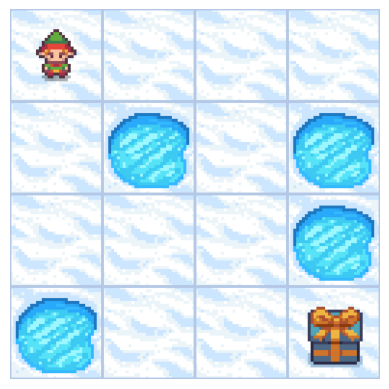

Transition Prob: 
[[0.33333333 0.33333333 0.         0.        ]
 [0.33333333 0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]]
Action: right
Observation: frozen


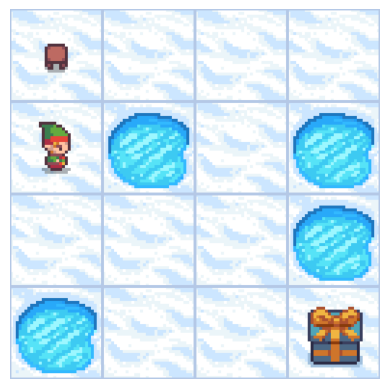

Transition Prob: 
[[0.         0.         0.         0.        ]
 [0.33333333 0.33333333 0.         0.        ]
 [0.33333333 0.         0.         0.        ]
 [0.         0.         0.         0.        ]]
Action: down
Observation: frozen


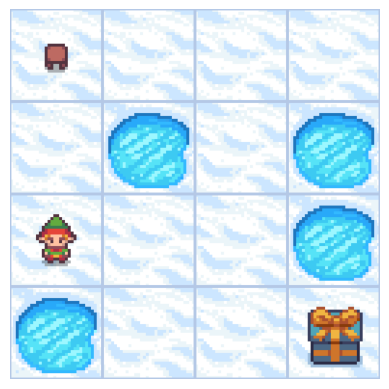

Transition Prob: 
[[0.         0.         0.         0.        ]
 [0.33333333 0.         0.         0.        ]
 [0.         0.33333333 0.         0.        ]
 [0.33333333 0.         0.         0.        ]]
Action: right
Observation: hole


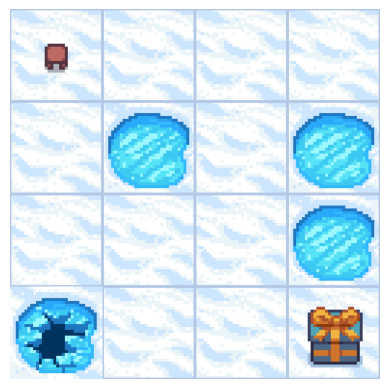

Transition Prob: 
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [1. 0. 0. 0.]]
Action: stay
Observation: hole


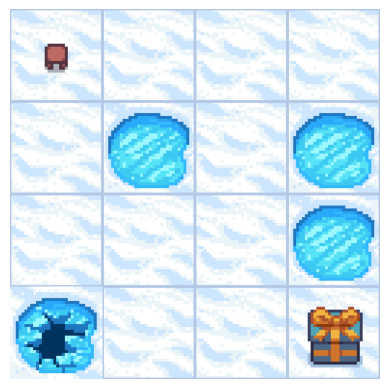

Transition Prob: 
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [1. 0. 0. 0.]]
Action: down
Observation: hole


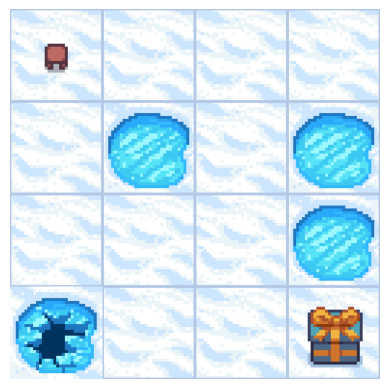

Transition Prob: 
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 1. 0. 0.]]
Action: right
Observation: frozen


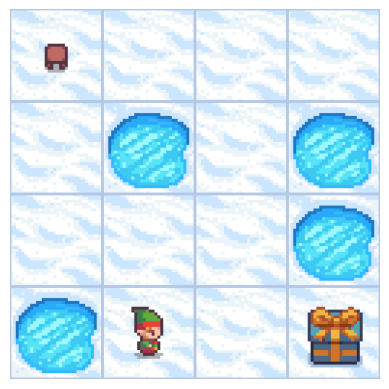

Transition Prob: 
[[0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.33333333 0.33333333 0.33333333 0.        ]]
Action: down
Observation: hole


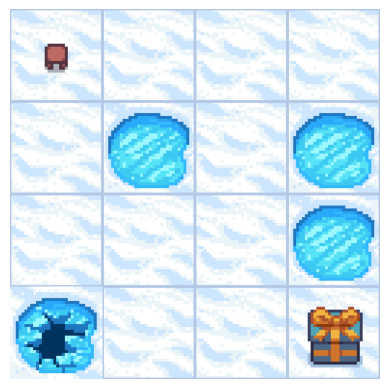

Transition Prob: 
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [1. 0. 0. 0.]]
Action: left
Observation: hole


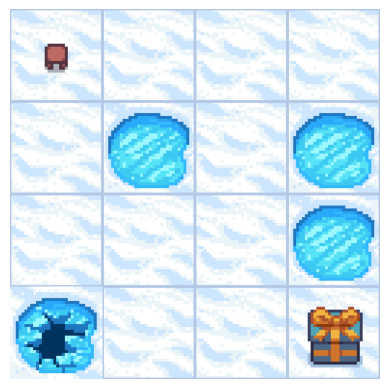

Transition Prob: 
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [1. 0. 0. 0.]]
Action: down
Observation: hole


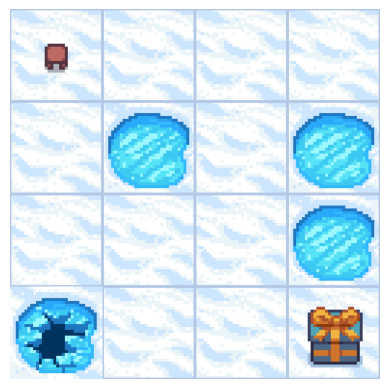

Transition Prob: 
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 0.]]
Action: up
Observation: frozen


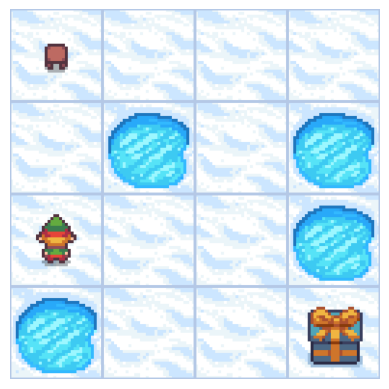

Transition Prob: 
[[0.         0.         0.         0.        ]
 [0.33333333 0.         0.         0.        ]
 [0.         0.33333333 0.         0.        ]
 [0.33333333 0.         0.         0.        ]]
Action: right
Observation: frozen


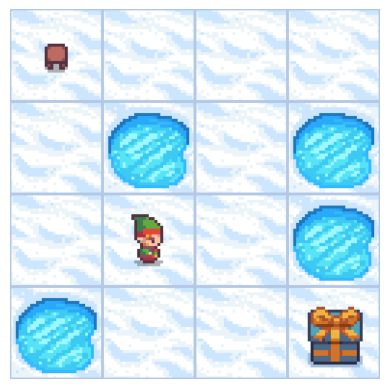

Transition Prob: 
[[0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.33333333 0.         0.33333333 0.        ]
 [0.         0.33333333 0.         0.        ]]
Action: down
Observation: frozen


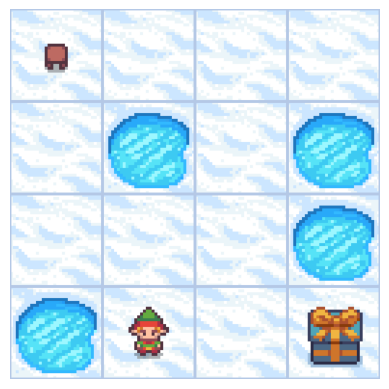

In [6]:
env.reset()

def render_img(env):
  img = env.render()
  plt.imshow(img)
  plt.axis('off')
  plt.show()

render_img(env)

# lets test some preset movements and render the images
test_action_labels = ['right', 'down', 'right','stay', 'down', 'right', 'down', 'left','down','up','right','down']
test_actions = [env.action_labels.index(action) for action in test_action_labels]

B = env.get_exact_transition_dynamics()
state = start_loc

for a in test_actions:
  print(f'Transition Prob: \n{B[:,state, a].reshape(4,4)}')
  state, obs = env.step(a)
  print(f'Action: {env.action_labels[a]}')
  print(f'Observation: {env.observation_labels[obs]}')
  render_img(env)

# Generative Model

## Defining state and observation factorizations

Only variable state is agents location.
For a static map, the reward observation actually isn't necessary because the location is exactly representative of what observations we want prefer. When the goal and the holes are randomized, then we need to know what we observe at each location bc its not a constant we have pre-modeled.

In [7]:
''' Define state factorization '''
# start with only dynamic variable being agents location
num_states = num_grid_points

''' Define observation factorization '''
# rewards are no reward (frozen tiles), goal (shelter), or hole (death)
reward_names = ['None', 'Goal', 'Hole']

num_obs = [num_grid_points, len(reward_names)]

print(f'Dimensionality of hidden states: {num_states}')
print(f'Dimensionality of observations: {num_obs}')

Dimensionality of hidden states: 16
Dimensionality of observations: [np.int64(16), 3]


## Defining observation likleihood:
Observation likelihood is rerpresented using matrix $A_{jk}=p(o=j|s_i=k)$ for each hidden factor $s_i$

In [8]:
# each modality A[m] is a conditional dist so [o_dim, states] where states are conditioned on
A_m_shapes = [ [o_dim] + [num_states] for o_dim in num_obs]
A = utils.obj_array_zeros(A_m_shapes)

''' Location factor '''
# start with proprioceptive (exact) observations about location
A[0] = np.eye(num_obs[0], num_states)

''' Reward factor'''
# receieve no reward at all states
A[1][0,:] = 1.0
# except receive reward when goal is reached
A[1][0, goal_loc] = 0.0
A[1][1, goal_loc] = 1.0
# and receive "hole" reward when falling in holes
for hole_loc in holes:
  A[1][0, hole_loc] = 0.0
  A[1][2, hole_loc] = 1.0

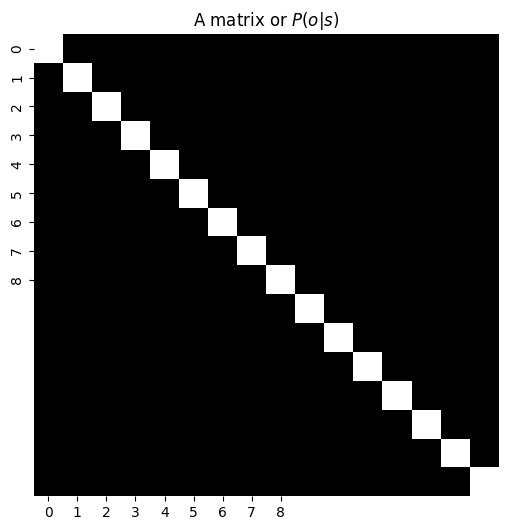

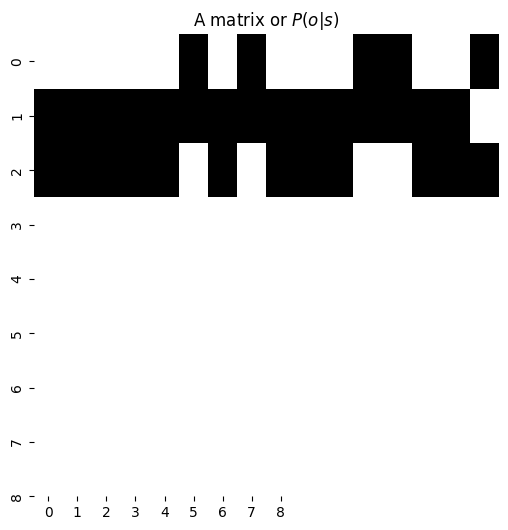

In [9]:
# TODO: make our own plotting functions
# observed state always matches the true location state
plot_likelihood(A[0], title_str = "A matrix or $P(o|s)$")
plot_likelihood(A[1], title_str = "A matrix or $P(o|s)$")

## Define transition dynamics $p(s_{t+1}|s_{t},\pi_{t})$
The transition matrix $B$ is dependent on the action being:
 $$B[i,j,k] = p(s_{t+1}=i|s_{t}=j,\pi_{t}=k)$$

We introduce an extra action "stay" in the grid world. This way our agent can choose to stay in the "shelter".

For now we only have a single factorization of the hidden state (location) so this is all we have to worry about

In [10]:
# import pymdp.envs

action_labels = ['left', 'down', 'right', 'up', 'stay']
num_actions = len(action_labels)

# B = pymdp.envs.GridWorldEnv([4,4],0).get_transition_dist()

# if is slippery than there is 1/3 chance of moving in perpendicular direction
# B[next state, curr state, action]
B_true = env.get_exact_transition_dynamics()
# B = utils.obj_array_zeros([ [num_states, num_states, num_actions] ])
# B[0] = GridWorldEnv([4,4],0).get_transition_dist()

## Define prior preferences (C) over observations
The only observation our agent should care about is the value of the reward observation factorization.
We can maybe rename this to the temperature observation?

In [11]:
C = utils.obj_array_zeros(num_obs)
# prefer shelter observation
C[1][reward_names.index('Goal')] = 4.0
# prefer not falling into holes
C[1][reward_names.index('Hole')] = -4.0

## Define the prior over hidden states $p(s_{t=1})$
Prior belief of agents location at the first time step. For now lets assume the agent knows it begins in the true hidden state top left corner.

In [12]:
D = utils.onehot(0, num_states)

# Active Inference

In [13]:
from scipy.special import kl_div
# define a non slippery environment to get a prior pB to learn the slippery dynamics
# env_non_slippery = gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=False, render_mode="rgb_array")
# env_non_slippery = FrozenLakeWrapper(env_non_slippery, is_slippery=False)

# gridworld_dynamics = env_non_slippery.get_exact_transition_dynamics()
# B = utils.obj_array_zeros([ [num_states, num_states, num_actions] ])
# B[0] = gridworld_dynamics 
# pB = B*2

B = utils.obj_array_zeros([ [num_states, num_states, num_actions] ])
# start with prior that our agent can only move to adjacent states, 
# i.e. actions lead to some adjacent state with equal probability
B[0] = env.get_naive_transition_dynamics()
# our dirichlet prior indicates how much to prefer this prior over the learned dynamics
# lets keep it small for now
pB = B * 1

def kl_divergence_transition_matrix(B1, B2):
    """
    Compute the KL divergence between two transition matrices
    """
    if not np.isclose(B1.sum(axis=0), 1.0).all():
      raise ValueError(f"B1 not normalized")
    if not np.isclose(B2.sum(axis=0), 1.0).all():
      raise ValueError(f"B2 not normalized")

    # avoid divide by 0 issue (looks like kl_div does this)
    # B2 = B2 + 1e-10
    
    kl_divs = np.zeros((B1.shape[1], B1.shape[2]))
    # kl divergence is an expectation over probabliy dist so we need to sum over the next states 
    for state in range(B1.shape[1]):
      for action in range(B1.shape[2]):
        # TODO: see if the line below is correct
        # kl_div[state, action] = np.sum(B1[:,state,action] * (np.log(B1[:,state,action]) - np.log(B2[:,state,action])))
        kl_divs[state, action] = np.sum(kl_div(B1[:,state,action], B2[:,state,action]))
        
    return np.mean(kl_divs)

print(kl_divergence_transition_matrix(B[0], B[0]))
print(kl_divergence_transition_matrix(B_true, B[0]))
# TODO: calculate KL divergence between dirichlet as well 
# def kl_divergence_dirichlet(pB1, pB2):

0.0
0.7890278780867023


In [14]:
# define agent with our generative model
# policy_len=6 to compute the EFE over 6 timesteps in the future
# factors_to_learn='all' or 0 because we only have one factor rn
agent = Agent(A = A, B = B, C = C, D = D, policy_len=6, pB=pB, factors_to_learn='all') 

In [28]:
from tqdm import tqdm
from pymdp import inference, control, learning


obs_history_list = []
mean_kl_divs = []
trajectory_goals = []
trajectory_holes = []

# qs_prev = agent.qs.copy()

# store the p(a|s) for future use
# stored as a probabiltiy distribution over actions for each state
# should actually be stored as prob distribution over actions given a prob distrubtion over states (we simplify the problem)
# TODO use a neural network to learn the policy: input = q_s, output = p_a
# habitual_table = np.zeros((num_states, num_actions))

def get_habitual_table():
    habitual_table = []
    for state in range(num_states):
        # set q_s to one-hot encoding for state
        qs_state = [utils.onehot(state, num_states)]
        # infer the policy
        q_pi, G = control.update_posterior_policies(
                qs_state,
                agent.A,
                agent.B,
                agent.C,
                agent.policies,
                agent.use_utility,
                agent.use_states_info_gain,
                agent.use_param_info_gain,
                agent.pA,
                agent.pB,
                E = agent.E,
                gamma = agent.gamma
            )
        habitual_table.append(q_pi)
    return habitual_table

def evaluate_trajectory(observation_history):
    '''
    Evaluate how often the agent observes reward vs holes
    '''
    num_holes, num_goals = 0, 0
    for obs in observation_history:
        if obs[1] == reward_names.index('Goal'):
            num_goals += 1
        elif obs[1] == reward_names.index('Hole'):
            num_holes += 1
    return num_holes, num_goals

epochs = 12 
T = 2000 # single trajectory timesteps

for epoch in range(epochs):
    # run through a single trajectory
    env.reset()

    # reset posterior beliefs to the prior
    agent.reset()

    # start by observing we are indeed at the starting location
    obs = [start_loc, reward_names.index('None')]
    obs_history = [obs]

    # update the table with EFE for discrete states
    habitual_table = get_habitual_table()

    for t in tqdm(range(T)):

        # get posterior belief based on observation
        qs = agent.infer_states(obs)
        # plot_beliefs_2D(qs[0].reshape(4,4), title_str = f"Beliefs about location at time {t}")

        # start updating B after first step (we need a qs_prev)
        if t > 0:
            last_state = obs_history[-2][0]
            # print(f"state: {state}, last state: {last_state}, action: {action}")
            # print('B before', agent.B[0][state, last_state, action ])
            agent.update_B(qs_prev)
            # print('B after', agent.B[0][state, last_state, action ])
            mean_kl_divs.append(kl_divergence_transition_matrix(B_true, agent.B[0]))

        ''' calculate the EFE and sample action '''
        # # calculate and infer a policy from EFE
        # agent.infer_policies()
        # # sample from marginalized EFE over next actions
        # action = agent.sample_action()
        # action = int(action[0])
        # print(f'Action at time {t}: {action_labels[action]}')

        ''' get the action from the table '''
        # get the action from the table
        habitual_q_pi = habitual_table[np.argmax(qs[0])]
        # habitual_policiy = habitual_table[obs[0]]
        action = control.sample_action(
                habitual_q_pi, agent.policies, agent.num_controls, action_selection = agent.action_selection, alpha = agent.alpha
            ) 
        agent.action = action 
        # only one control to get action from
        action = int(action[0])
        agent.step_time()

        ''' randomly sample an action '''
        # action = np.random.choice(range(num_actions))
        # # action_factors = utils.obj_array_zeros(1)
        # # action_factors[0] = np.array([action])
        # agent.action = np.array([action ])
        # agent.step_time()

        # save our last beleif before taking next action
        qs_prev = qs.copy()

        # get the new state after taking the sampled action
        state, obs_ground = env.step(action)
        # show the movement
        # render_img(env)
        # update the new observation
        obs = [state, obs_ground]
        obs_history.append(obs)
        
    obs_history_list.append(obs_history)
    
    # calculate how often the agent observes reward vs holes for the entire trajectory
    num_holes, num_goals = evaluate_trajectory(obs_history)
    trajectory_goals.append(num_goals)
    trajectory_holes.append(num_holes)

runs.append([
obs_history_list,
mean_kl_divs,
trajectory_goals,
trajectory_holes])


100%|██████████| 2000/2000 [01:26<00:00, 23.25it/s]


# Results exploration and plotting

In [33]:
runs[-1][-3]

[np.float64(0.015979741082031606),
 np.float64(0.01599861894334064),
 np.float64(0.016020233620295143),
 np.float64(0.01603494828423014),
 np.float64(0.016009121303132916),
 np.float64(0.016016740939093076),
 np.float64(0.01603871994640512),
 np.float64(0.01604984610484065),
 np.float64(0.016036333464729425),
 np.float64(0.01604217889290519),
 np.float64(0.016040325530903128),
 np.float64(0.01603777529117175),
 np.float64(0.01603531199428724),
 np.float64(0.016032931268634865),
 np.float64(0.016030629030853238),
 np.float64(0.016028401462460994),
 np.float64(0.016026244988721496),
 np.float64(0.016024156259499496),
 np.float64(0.016022132131894067),
 np.float64(0.016020169654458526),
 np.float64(0.01601826605284059),
 np.float64(0.016016418716695947),
 np.float64(0.01601462518774531),
 np.float64(0.016012883148860187),
 np.float64(0.016011190414075283),
 np.float64(0.016009544919437218),
 np.float64(0.016007944714608816),
 np.float64(0.016006387955157273),
 np.float64(0.016004872895462

In [65]:
trajectory_goals_l = list( np.array(runs[-2][-2]) *2000 / 5000) + runs[-1][-2]
trajectory_holes_l = list( np.array(runs[-2][-1]) *2000 / 5000) + runs[-1][-1]

In [ ]:
runs[-2][-3] + runs[-1][-3]

[np.float64(0.780363538329703),
 np.float64(0.7784366548318623),
 np.float64(0.7813247680841953),
 np.float64(0.7784366548318623),
 np.float64(0.7813247680841954),
 np.float64(0.7698711339357684),
 np.float64(0.767592114475844),
 np.float64(0.7695504629310345),
 np.float64(0.7580968287826076),
 np.float64(0.7600551772377981),
 np.float64(0.7577761577778738),
 np.float64(0.7597345062330644),
 np.float64(0.7580968287826076),
 np.float64(0.7592955040844901),
 np.float64(0.7604941793863725),
 np.float64(0.7467615257780211),
 np.float64(0.7479602010799036),
 np.float64(0.7342275474715522),
 np.float64(0.7354262227734345),
 np.float64(0.7373845712286251),
 np.float64(0.7393429196838157),
 np.float64(0.7306785799268164),
 np.float64(0.7192249457783895),
 np.float64(0.7077713116299625),
 np.float64(0.6963176774815356),
 np.float64(0.6848640433331086),
 np.float64(0.6825850238731842),
 np.float64(0.6711313897247573),
 np.float64(0.6687340391209924),
 np.float64(0.666455019661068),
 np.float64(0

In [64]:
mean_kl_divs_l = [el for (i, el) in enumerate(runs[-2][-3]) if i%5==0 or i%5==2] + runs[-1][-3]
len(mean_kl_divs_l)

29987

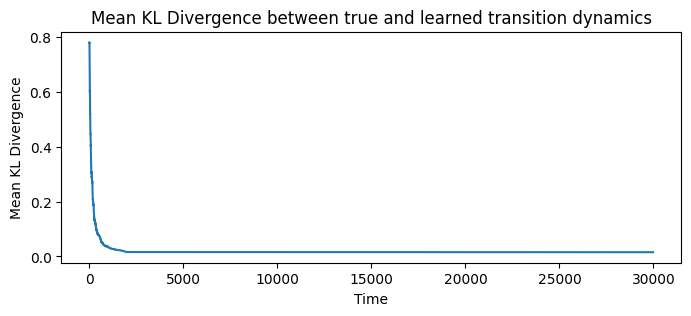

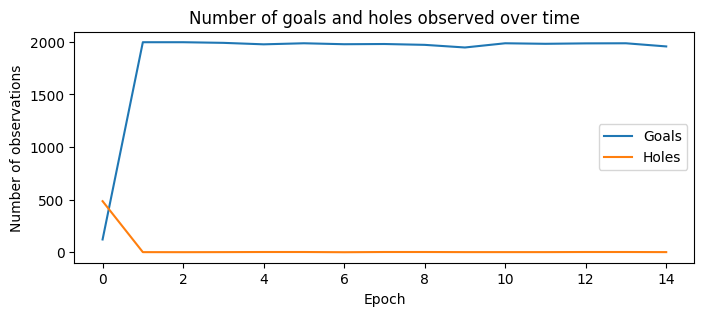

In [87]:
# plot the KL divergence over time
plt.figure(figsize=(8, 3))
plt.plot(mean_kl_divs_l, label='Mean KL Divergence')
# plt.plot(distances, label='L2 distance')
plt.xlabel('Time')
plt.ylabel('Mean KL Divergence')
plt.title('Mean KL Divergence between true and learned transition dynamics')
plt.show()

# plot the number of holes and goals observed over time
plt.figure(figsize=(8, 3))
plt.plot(trajectory_goals_l, label='Goals')
plt.plot(trajectory_holes_l, label='Holes')
plt.xlabel('Epoch')
plt.ylabel('Number of observations')
plt.title('Number of goals and holes observed over time')
plt.legend()
plt.show()

In [84]:
import json
mean_kl_divs     = np.array(mean_kl_divs_l)  # Example decay for KL divergence
trajectory_goals = np.array(trajectory_goals_l)
trajectory_holes = np.array(trajectory_holes_l)
for i, array in enumerate([mean_kl_divs, trajectory_goals, trajectory_holes]):
    
    # Convert the array to a list
    array_list = array.tolist()

    # Specify the file path
    file_path = f"array_data_{i}.json"

    # Save the list to a JSON file
    with open(file_path, "w") as json_file:
        json.dump(array_list, json_file, indent=4)

    print(f"NumPy array saved to {file_path}")

NumPy array saved to array_data_0.json
NumPy array saved to array_data_1.json
NumPy array saved to array_data_2.json


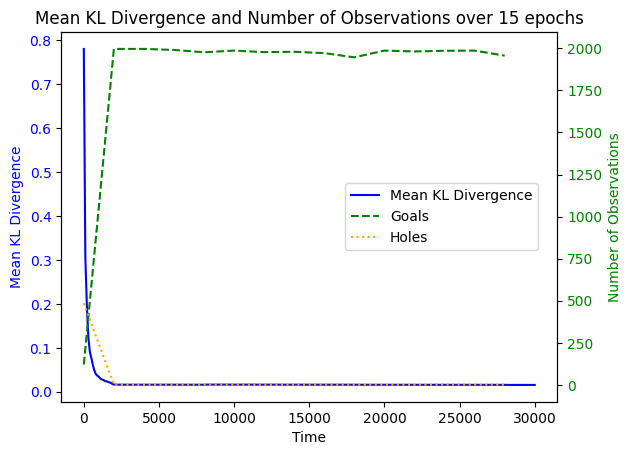

In [79]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming data is provided as arrays. Replace these arrays with actual data.
# Mock data for demonstration purposes
time_steps = np.linspace(0, 30000, 300)

epochs = np.arange(0, 15, 1)
mean_kl_divs     = np.array([el for i, el in enumerate(mean_kl_divs_l) if i%100==0])  # Example decay for KL divergence
trajectory_goals = np.array(trajectory_goals_l)
trajectory_holes = np.array(trajectory_holes_l)

# Convert epoch data to time scale (1 epoch = 2000 timesteps)
trajectory_time = epochs * 2000

fig, ax1 = plt.subplots()

# Plot Mean KL Divergence on the left y-axis
ax1.plot(time_steps, mean_kl_divs, label="Mean KL Divergence", color="blue")
ax1.set_xlabel("Time")
ax1.set_ylabel("Mean KL Divergence", color="blue")
ax1.tick_params(axis="y", labelcolor="blue")

# Create a second y-axis for the number of observations
ax2 = ax1.twinx()
ax2.plot(trajectory_time, trajectory_goals, label="Goals", color="green", linestyle="dashed")
ax2.plot(trajectory_time, trajectory_holes, label="Holes", color="orange", linestyle="dotted")
ax2.set_ylabel("Number of Observations", color="green")
ax2.tick_params(axis="y", labelcolor="green")

# Add legends
fig.legend(loc="center right", bbox_to_anchor=(0.975, 0.5), bbox_transform=ax1.transAxes)
plt.title("Mean KL Divergence and Number of Observations over 15 epochs")
plt.show()


In [24]:
obs_history_list

[[[0, 0],
  [np.int64(0), 0],
  [np.int64(0), 0],
  [0, 0],
  [0, 0],
  [1, 0],
  [1, 0],
  [1, 0],
  [2, 0],
  [2, 0],
  [2, 0],
  [2, 0],
  [2, 0],
  [6, 0],
  [10, 0],
  [6, 0],
  [6, 0],
  [5, 2],
  [9, 0],
  [13, 0],
  [14, 0],
  [15, 1],
  [11, 2],
  [7, 2],
  [7, 2],
  [11, 2],
  [11, 2],
  [7, 2],
  [6, 0],
  [7, 2],
  [6, 0],
  [10, 0],
  [14, 0],
  [13, 0],
  [13, 0],
  [13, 0],
  [14, 0],
  [13, 0],
  [12, 2],
  [12, 2],
  [13, 0],
  [13, 0],
  [13, 0],
  [14, 0],
  [13, 0],
  [14, 0],
  [14, 0],
  [14, 0],
  [14, 0],
  [15, 1],
  [15, 1],
  [11, 2],
  [10, 0],
  [11, 2],
  [10, 0],
  [14, 0],
  [10, 0],
  [9, 0],
  [10, 0],
  [11, 2],
  [10, 0],
  [6, 0],
  [2, 0],
  [6, 0],
  [7, 2],
  [6, 0],
  [7, 2],
  [7, 2],
  [11, 2],
  [15, 1],
  [15, 1],
  [15, 1],
  [11, 2],
  [15, 1],
  [14, 0],
  [10, 0],
  [14, 0],
  [13, 0],
  [12, 2],
  [12, 2],
  [12, 2],
  [8, 0],
  [9, 0],
  [8, 0],
  [8, 0],
  [12, 2],
  [12, 2],
  [12, 2],
  [8, 0],
  [8, 0],
  [8, 0],
  [8, 0],
  [12, 2

In [ ]:
runs.append()

In [25]:
runs = [[
obs_history_list,
mean_kl_divs,
trajectory_goals,
trajectory_holes]]

In [26]:
runs

[[[[[0, 0],
    [np.int64(0), 0],
    [np.int64(0), 0],
    [0, 0],
    [0, 0],
    [1, 0],
    [1, 0],
    [1, 0],
    [2, 0],
    [2, 0],
    [2, 0],
    [2, 0],
    [2, 0],
    [6, 0],
    [10, 0],
    [6, 0],
    [6, 0],
    [5, 2],
    [9, 0],
    [13, 0],
    [14, 0],
    [15, 1],
    [11, 2],
    [7, 2],
    [7, 2],
    [11, 2],
    [11, 2],
    [7, 2],
    [6, 0],
    [7, 2],
    [6, 0],
    [10, 0],
    [14, 0],
    [13, 0],
    [13, 0],
    [13, 0],
    [14, 0],
    [13, 0],
    [12, 2],
    [12, 2],
    [13, 0],
    [13, 0],
    [13, 0],
    [14, 0],
    [13, 0],
    [14, 0],
    [14, 0],
    [14, 0],
    [14, 0],
    [15, 1],
    [15, 1],
    [11, 2],
    [10, 0],
    [11, 2],
    [10, 0],
    [14, 0],
    [10, 0],
    [9, 0],
    [10, 0],
    [11, 2],
    [10, 0],
    [6, 0],
    [2, 0],
    [6, 0],
    [7, 2],
    [6, 0],
    [7, 2],
    [7, 2],
    [11, 2],
    [15, 1],
    [15, 1],
    [15, 1],
    [11, 2],
    [15, 1],
    [14, 0],
    [10, 0],
    [14, 0],
    [13, 0]

In [38]:
runs[-1][0]

[[[0, 0],
  [0, 0],
  [0, 0],
  [0, 0],
  [1, 0],
  [2, 0],
  [6, 0],
  [2, 0],
  [6, 0],
  [10, 0],
  [11, 2],
  [15, 1],
  [15, 1],
  [15, 1],
  [15, 1],
  [15, 1],
  [15, 1],
  [15, 1],
  [15, 1],
  [15, 1],
  [15, 1],
  [15, 1],
  [15, 1],
  [15, 1],
  [15, 1],
  [15, 1],
  [15, 1],
  [15, 1],
  [15, 1],
  [15, 1],
  [15, 1],
  [15, 1],
  [15, 1],
  [15, 1],
  [15, 1],
  [15, 1],
  [15, 1],
  [15, 1],
  [15, 1],
  [15, 1],
  [15, 1],
  [15, 1],
  [15, 1],
  [15, 1],
  [15, 1],
  [15, 1],
  [15, 1],
  [15, 1],
  [15, 1],
  [15, 1],
  [15, 1],
  [15, 1],
  [15, 1],
  [15, 1],
  [15, 1],
  [15, 1],
  [15, 1],
  [15, 1],
  [15, 1],
  [15, 1],
  [15, 1],
  [15, 1],
  [15, 1],
  [15, 1],
  [15, 1],
  [15, 1],
  [15, 1],
  [15, 1],
  [15, 1],
  [15, 1],
  [15, 1],
  [15, 1],
  [15, 1],
  [15, 1],
  [15, 1],
  [15, 1],
  [15, 1],
  [15, 1],
  [15, 1],
  [15, 1],
  [15, 1],
  [15, 1],
  [15, 1],
  [15, 1],
  [15, 1],
  [15, 1],
  [15, 1],
  [15, 1],
  [15, 1],
  [15, 1],
  [15, 1],
  [15, 1

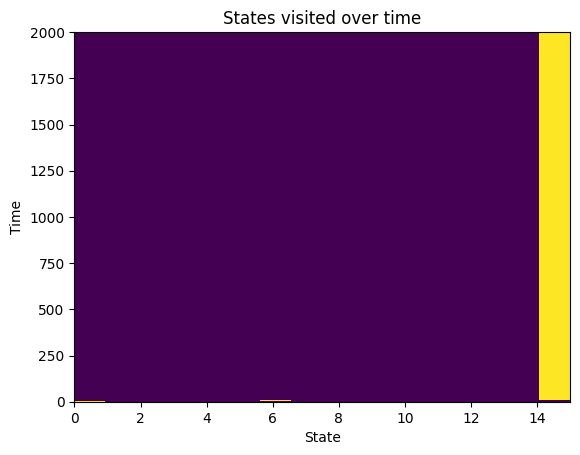

<BarContainer object of 16 artists>

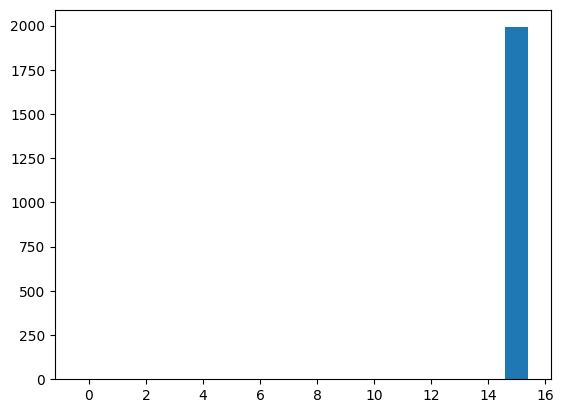

In [41]:
states = [obs[0] for obs in runs[-1][0][0]]
# plot heatmap of states visited
plt.hist2d(states, range(len(states)), bins=(num_states, len(states)), cmap=plt.cm.viridis)
plt.ylabel('Time')
plt.xlabel('State')
plt.title('States visited over time')
plt.show()

# plot heatmap of states visited
# count states visited
counts = np.zeros(num_states)
for state in states:
    counts[state] += 1
plt.bar(range(num_states), counts)

# fig = plt.figure(figsize = (4,4))
# ax = sns.heatmap(states, cmap = 'RdYlGn', cbar = False, vmin = 0.0, vmax = 1.0)
# plt.show()


